In [1]:
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from scipy.stats import uniform,norm,t,binom,expon,chi2,gamma,poisson,beta,dirichlet
from scipy.stats import multivariate_normal as multi_norm
from sklearn.linear_model import LinearRegression as Linear
from scipy.optimize import brentq,minimize
from scipy.special import perm,comb
import time
import pandas as pd
import qmcpy as qp

import warnings
warnings.filterwarnings("ignore")

**15.8**

In [2]:
def draw():
    samples=ld.gen_samples(n)[:,select]
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    ax[0].scatter(samples[:,0],samples[:,1])
    ax[0].set_xlabel('D-'+str(select[0]+1))
    ax[0].set_ylabel('D-'+str(select[1]+1))
    ax[1].scatter(samples[:,2],samples[:,3])
    ax[1].set_xlabel('D-'+str(select[2]+1))
    ax[1].set_ylabel('D-'+str(select[3]+1))
    plt.show()

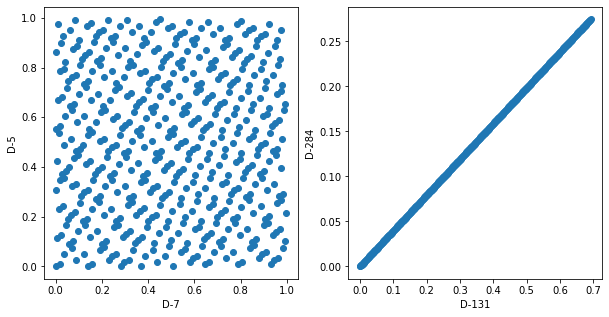

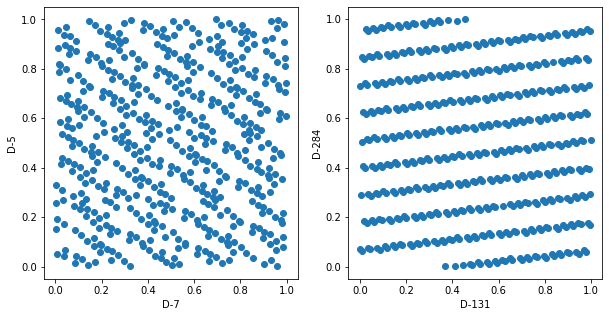

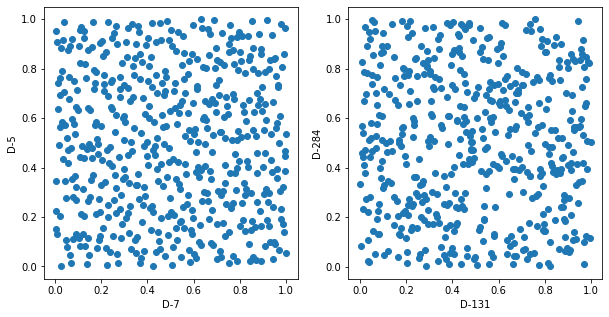

In [3]:
d=360
n=2**9
select=np.append(np.random.choice(np.arange(10),2,replace=False),\
                 np.random.choice(np.arange(d),2,replace=False))
ld=qp.Halton(d,randomize=False)
draw()
ld=qp.Halton(d,randomize='QRNG')
draw()
ld=qp.Halton(d,randomize='OWEN')
draw()

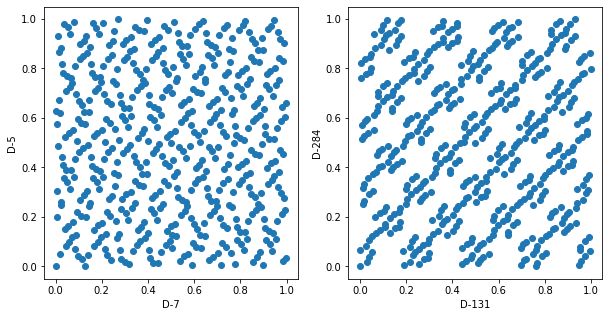

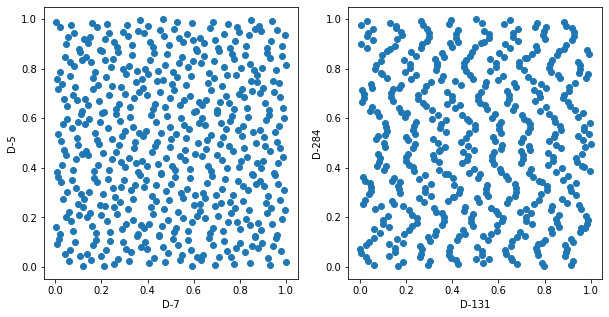

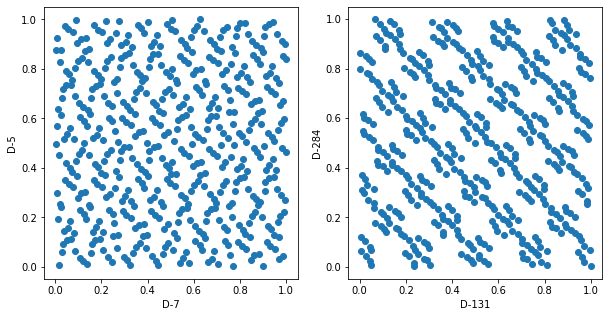

In [4]:
ld=qp.Sobol(d,randomize=False)
draw()
ld=qp.Sobol(d,randomize='LMS')
draw()
ld=qp.Sobol(d,randomize='DS')
draw()

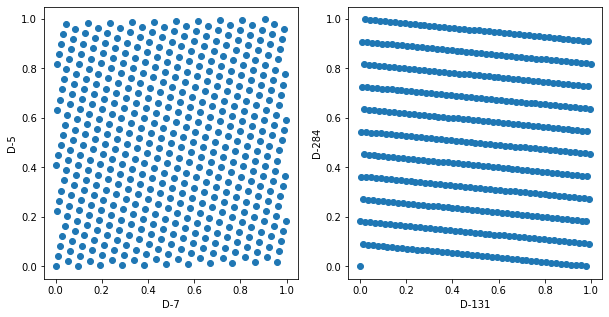

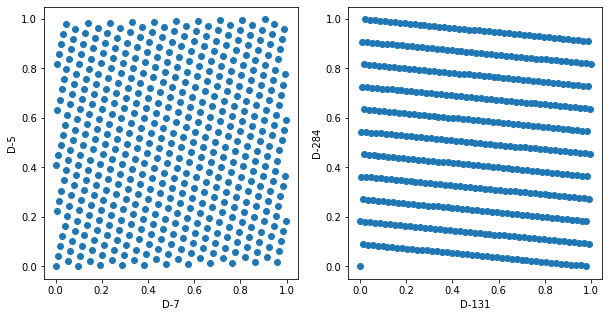

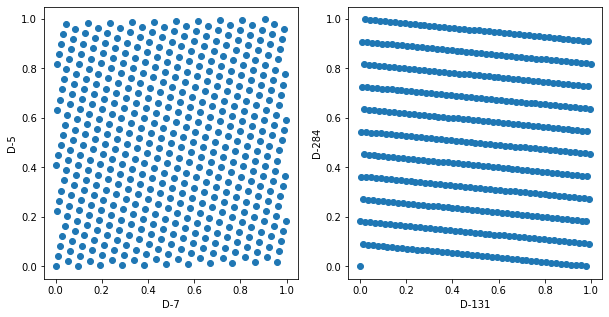

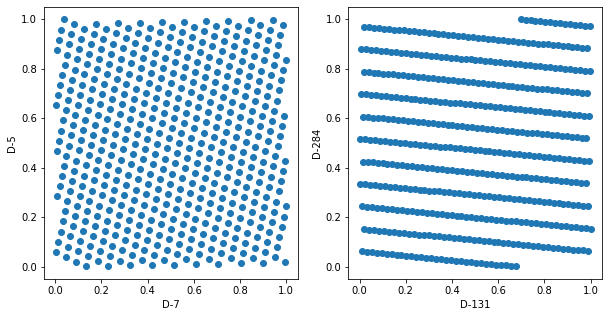

In [5]:
ld=qp.Lattice(d,randomize=False,order='natural')
draw()
ld=qp.Lattice(d,randomize=False,order='linear')
draw()
ld=qp.Lattice(d,randomize=False,order='mps')
draw()
ld=qp.Lattice(d,randomize=True)
draw()

**15.9**

In [6]:
def wing(X):
    tmp1=0.036*(X[:,0]**0.758)*(X[:,1]**0.0035)
    tmp2=(X[:,2]/np.cos(X[:,3])**2)**0.6
    tmp3=(X[:,4]**0.006)*(X[:,5]**0.04)
    tmp4=((100*X[:,6])/np.cos(X[:,3]))**(-0.3)
    tmp5=(X[:,7]*X[:,8])**0.49
    return tmp1*tmp2*tmp3*tmp4*tmp5+X[:,0]*X[:,9]

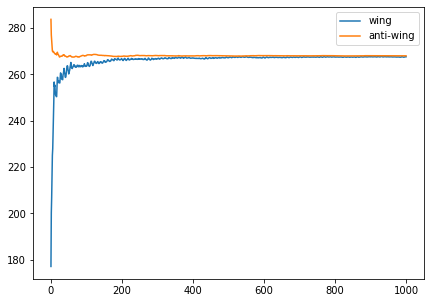

In [7]:
halton=qp.Halton(10,randomize=False)
lower_bound=[150,220,6,-np.pi/18,16,0.5,0.08,2.5,1700,0.025]
upper_bound=[200,300,10,np.pi/18,45,1,0.18,6,2500,0.08]
uniform=qp.Uniform(halton,lower_bound,upper_bound)
cf=qp.CustomFun(uniform,g=wing)

N=1000
means=np.zeros([N,2])
X=cf.discrete_distrib.gen_samples(2*N)
for i in range(N):
    y=cf.f(X[:(2*i+2)])
    means[i,0]=y.mean()
    y=(cf.f(X[:(i+1)])+cf.f(1-X[:(i+1)]))/2
    means[i,1]=y.mean()
    
fig,ax=plt.subplots(figsize=(7,5))
ax.plot(np.arange(N)+1,means[:,0],label='wing')
ax.plot(np.arange(N)+1,means[:,1],label='anti-wing')
ax.legend()
plt.show()

**15.11**

In [8]:
class syn:
    def __init__(self,Beta,G):
        self.d=Beta.size
        self.Beta=Beta
        self.G=G
        
    def f(self,X):
        y=np.ones(X.shape[0])
        for j in range(self.d):
            y*=1+self.Beta[j]*self.G[j](X[:,j])
        
        return y

def cummean(Y):
    return np.cumsum(Y)/np.cumsum(np.ones(Y.size))

In [9]:
def experiment():
    halton=qp.Halton(d,randomize=False)
    hS=halton.gen_samples(1500000)
    sobol=qp.Sobol(d,randomize=False)
    sS=sobol.gen_samples(2**21)

    Y1=cummean(f(hS))
    Y2=cummean(f(sS))
    Err1=np.abs(Y1-1)
    Err2=np.abs(Y2-1)

    halton=qp.Halton(d,randomize='QRNG')
    QhS=halton.gen_samples(1500000)
    halton=qp.Halton(d,randomize='OWEN')
    OhS=halton.gen_samples(1500000)
    sobol=qp.Sobol(d,randomize='LMS')
    LsS=sobol.gen_samples(2**21)
    sobol=qp.Sobol(d,randomize='DS')
    DsS=sobol.gen_samples(2**21)

    Y3=cummean(f(QhS))
    Err3=np.abs(Y3-1)
    Y4=cummean(f(OhS))
    Err4=np.abs(Y4-1)
    Y5=cummean(f(LsS))
    Err5=np.abs(Y5-1)
    Y6=cummean(f(DsS))
    Err6=np.abs(Y6-1)
    
    lattice=qp.Lattice(d,randomize=False)
    lS=lattice.gen_samples(1500000)
    lattice=qp.Lattice(d,randomize=True)
    RlS=lattice.gen_samples(1500000)
    
    Y7=cummean(f(lS))
    Err7=np.abs(Y7-1)
    Y8=cummean(f(RlS))
    Err8=np.abs(Y8-1)

    index=2**np.arange(7,21)-1
    fig,ax=plt.subplots(figsize=(7,5))
    ax.loglog(index+1,Err1[index],label='Halton')
    ax.loglog(index+1,Err2[index],label='Sobol')
    ax.loglog(index+1,Err3[index],label='QRNG Halton')
    ax.loglog(index+1,Err4[index],label='OWEN Halton')
    ax.loglog(index+1,Err5[index],label='LMS Sobol')
    ax.loglog(index+1,Err6[index],label='DS Sobol')
    ax.loglog(index+1,Err7[index],label='Lattice')
    ax.loglog(index+1,Err8[index],label='Rand Lattice')
    ax.legend()
    plt.show()

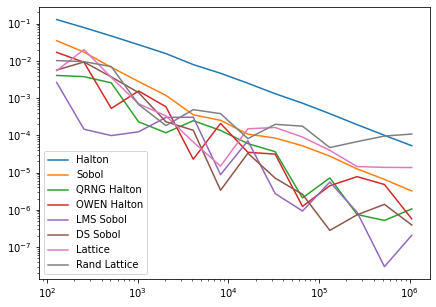

In [10]:
d=25
Beta=1/(2*np.arange(1,d+1))
G=[lambda x: np.sqrt(12)*(x-1/2) for j in range(d)]
f=syn(Beta,G).f
experiment()

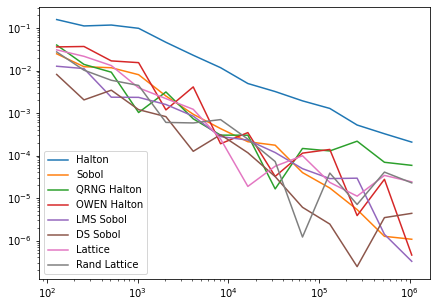

In [11]:
d=25
Beta=(1/(2*np.arange(d,0,-1)))
G=[lambda x: np.sqrt(12)*(x-1/2) for j in range(d)]
f=syn(Beta,G).f
experiment()